In [29]:
import pandas as pd
from sklearn.decomposition import PCA
import glob
import numpy as np 
from numpy import genfromtxt
from numpy import linalg as LA
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from mpl_toolkits import mplot3d
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

from utils import project

In [21]:
folders = glob.glob('???')

In [28]:
df = pd.read_csv('pivot_f.csv', sep=';', engine='python')
df

,Unnamed: 0,f__,f__Acetobacteraceae,f__Acidobacteriaceae,f__Actinomycetaceae,f__Aerococcaceae,f__Aeromonadaceae,f__Alcaligenaceae,f__Alicyclobacillaceae,f__Anaeroplasmataceae,...,f__Thermicanaceae,f__Thermodesulfovibrionaceae,f__Thermogemmatisporaceae,f__Thermomonosporaceae,f__Thiotrichaceae,f__Xenococcaceae,f__auto67_4W,f__mb2424,f__p-2534-18B5,f__wb1_P06
0,10317.000023651,0.068244,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10317.000023651999,0.115625,0.0,0.0,0.000195,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10317.000023653001,0.029501,0.0,0.0,0.000000,0.0,0.0,0.004772,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10317.000023655,0.020056,0.0,0.0,0.001851,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10317.000023655999,0.007242,0.0,0.0,0.000000,0.0,0.0,0.005663,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14093,MSM5LLIO,0.053115,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14094,MSM5LLIQ,0.099520,0.0,0.0,0.000000,0.0,0.0,0.077112,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14095,MSM5ZOJY,0.015819,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14096,MSM633FF,0.020097,0.0,0.0,0.000000,0.0,0.0,0.020655,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


DATASET: AGP, TAX: o
EV_NUM 16 REC_ERROR: 0.006094946154418277


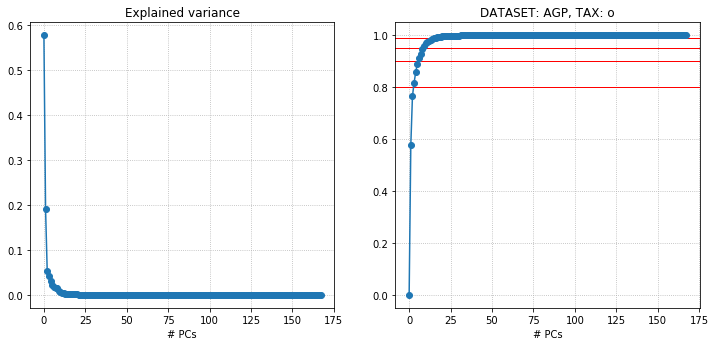

DATASET: AGP, TAX: f
EV_NUM 35 REC_ERROR: 0.003974872515576027


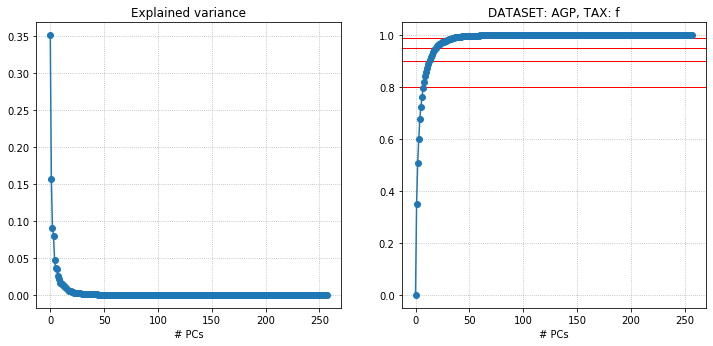

DATASET: AGP, TAX: g
EV_NUM 52 REC_ERROR: 0.0019385706228357011


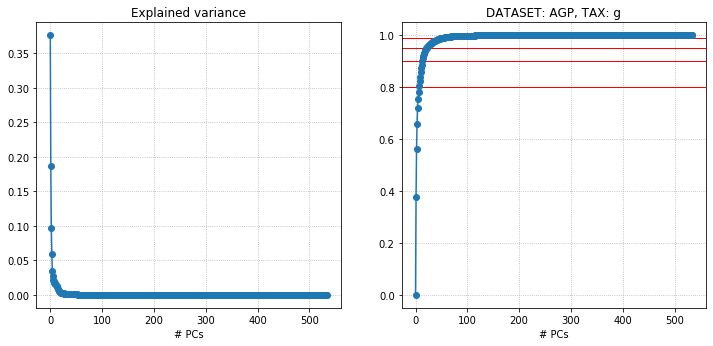

DATASET: ptb, TAX: o
EV_NUM 18 REC_ERROR: 0.010112303075050363


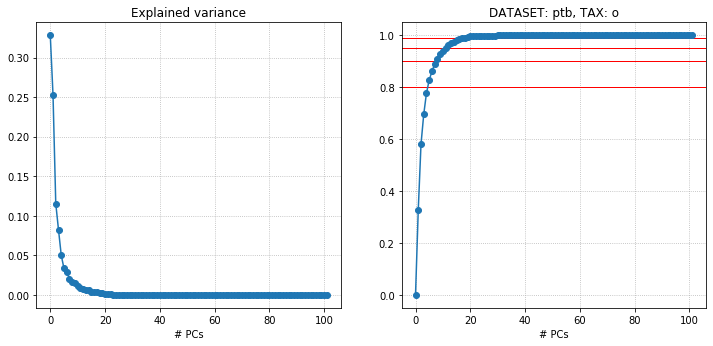

DATASET: ptb, TAX: f
EV_NUM 36 REC_ERROR: 0.006652057275221091


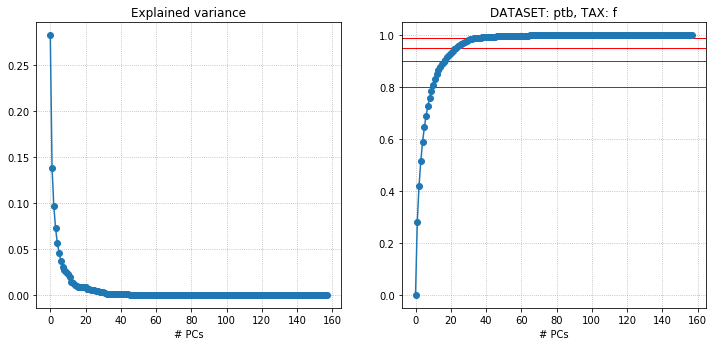

DATASET: ptb, TAX: g
EV_NUM 49 REC_ERROR: 0.0036179133231942174


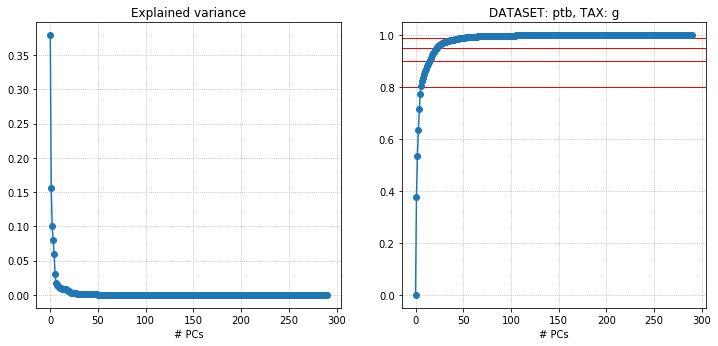

DATASET: t2d, TAX: o
EV_NUM 11 REC_ERROR: 0.016137899908491696


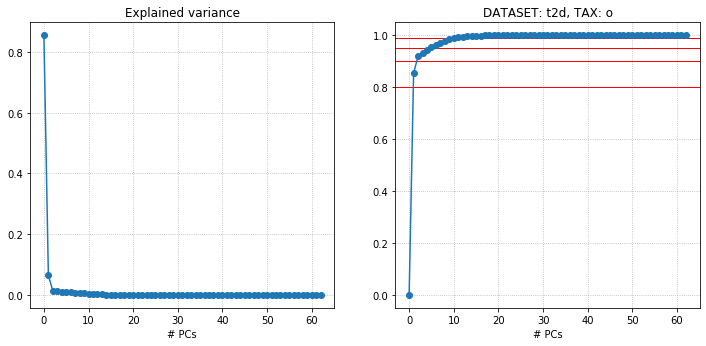

DATASET: t2d, TAX: f
EV_NUM 17 REC_ERROR: 0.008897327386809756


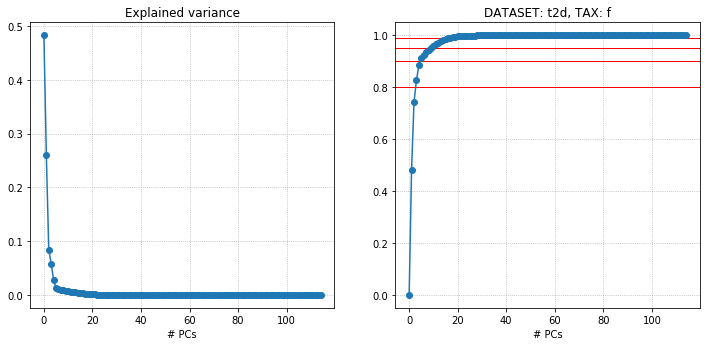

DATASET: t2d, TAX: g
EV_NUM 17 REC_ERROR: 0.0046670751525825


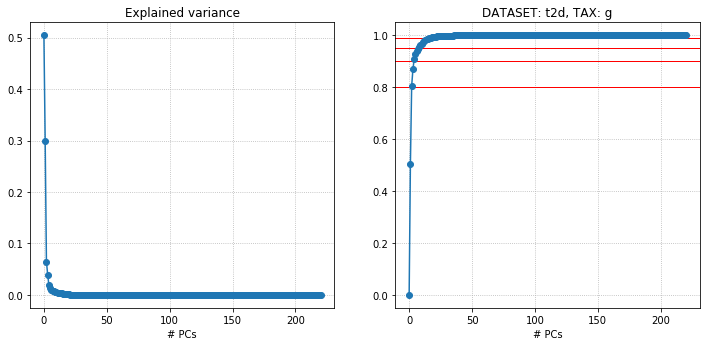

DATASET: ibd, TAX: o
EV_NUM 6 REC_ERROR: 0.03201722300252819


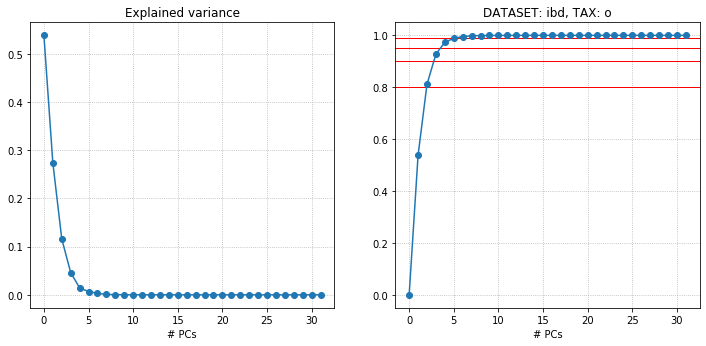

DATASET: ibd, TAX: f
EV_NUM 11 REC_ERROR: 0.016257777569541977


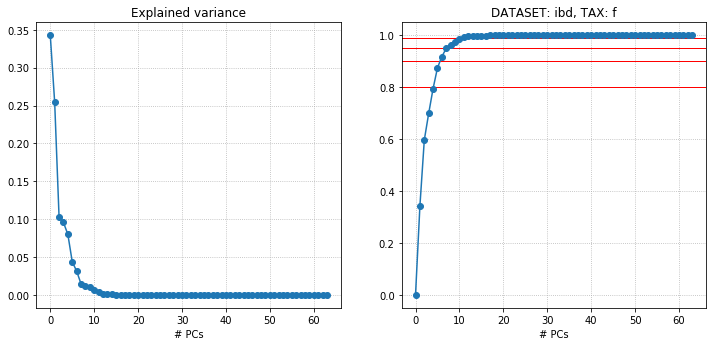

DATASET: ibd, TAX: g
EV_NUM 12 REC_ERROR: 0.009924331581244615


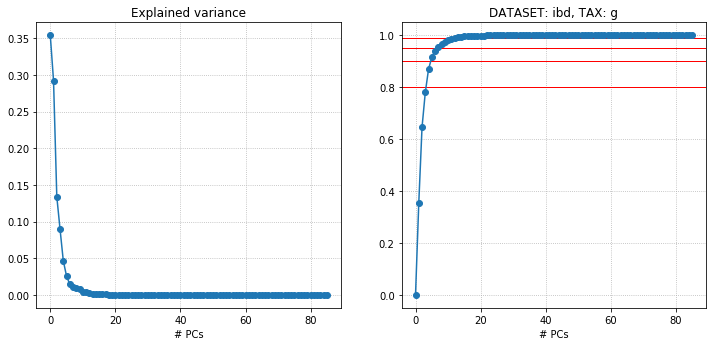

In [18]:
SAVE=False
datasets_taxes = defaultdict(dict)
for f in tqdm_notebook(folders):
    for t in ['o', 'f', 'g']:
        print(f'DATASET: {f}, TAX: {t}')
        dataframe = pd.read_csv(f'{f}/pivot_{t}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
        dataframe = dataframe.drop('Unnamed: 0', axis = 1)
        data_projected,_ = project(dataframe.values, plot=True)
        plt.title(f'DATASET: {f}, TAX: {t}')
        plt.show()
        if SAVE:
            np.savetxt(f'./separate_datasets_data/{f}_proj_{t}.csv', data_projected, delimiter = ';')